
--- Active Learning: Least Confidence ---
Initial Least Confidence - G-Mean: 0.7940, ROC-AUC: 0.8911
Iteration 1 (Least Confidence) - G-Mean: 0.8335, ROC-AUC: 0.8958
Iteration 2 (Least Confidence) - G-Mean: 0.8442, ROC-AUC: 0.8760
Iteration 3 (Least Confidence) - G-Mean: 0.8444, ROC-AUC: 0.8807
Iteration 4 (Least Confidence) - G-Mean: 0.8481, ROC-AUC: 0.8794
Iteration 5 (Least Confidence) - G-Mean: 0.8516, ROC-AUC: 0.8813

--- Active Learning: Entropy ---
Initial Entropy - G-Mean: 0.7940, ROC-AUC: 0.8911
Iteration 1 (Entropy) - G-Mean: 0.8335, ROC-AUC: 0.8958
Iteration 2 (Entropy) - G-Mean: 0.8442, ROC-AUC: 0.8760
Iteration 3 (Entropy) - G-Mean: 0.8444, ROC-AUC: 0.8807
Iteration 4 (Entropy) - G-Mean: 0.8481, ROC-AUC: 0.8794
Iteration 5 (Entropy) - G-Mean: 0.8516, ROC-AUC: 0.8813


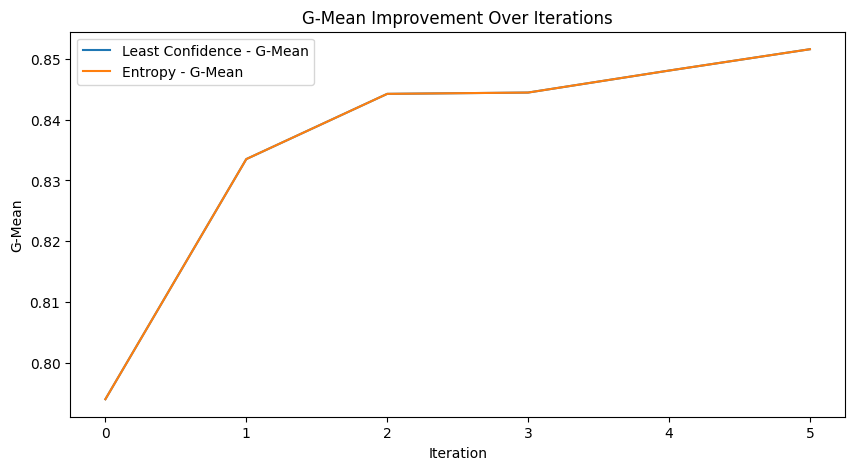

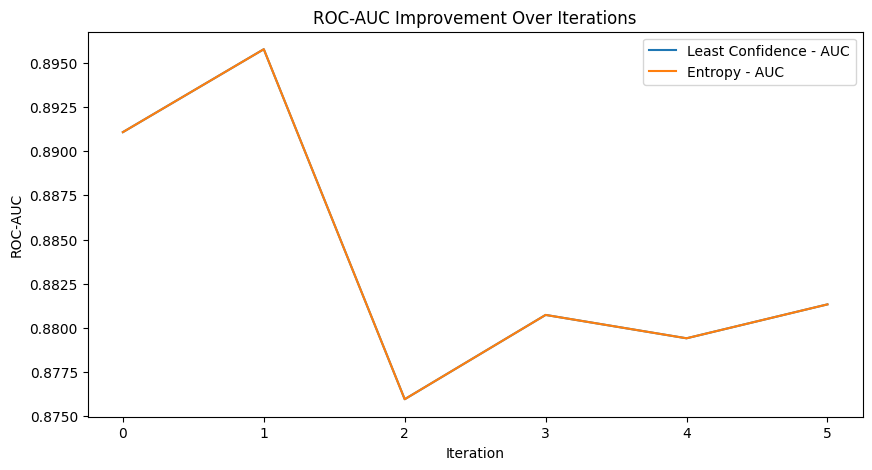

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score
from imblearn.metrics import geometric_mean_score

#-----------------------------------------
# Load and preprocess data (similar to Part-A)
#-----------------------------------------
train_data = pd.read_csv("Dataset-train-vf.csv")
test_data = pd.read_csv("Dataset-test-vf.csv")

# Encode categorical and target variables
encoded_train_data = pd.get_dummies(train_data, columns=['x14'])
encoded_test_data = pd.get_dummies(test_data, columns=['x14'])

encoded_train_data["y"] = encoded_train_data["y"].map(lambda x: 1 if x=="High" else 0)
encoded_test_data["y"] = encoded_test_data["y"].map(lambda x: 1 if x=="High" else 0)

# Drop sample column
encoded_train_data = encoded_train_data.drop(columns=['sample'])
encoded_test_data = encoded_test_data.drop(columns=['sample'])

# Handle missing values
encoded_train_data = encoded_train_data.drop(columns=['x2'])
encoded_test_data = encoded_test_data.drop(columns=['x2'])
encoded_train_data.fillna(encoded_train_data.mean(), inplace=True)
encoded_test_data.fillna(encoded_test_data.mean(), inplace=True)

# Identify skewed features and transform them
numerical_features = encoded_train_data.select_dtypes(include=['float64', 'int64']).columns.drop('y')
skewness = encoded_train_data[numerical_features].apply(lambda x: x.skew()).sort_values(ascending=False)
skewness_threshold = 0.5
skewed_features = skewness[abs(skewness) > skewness_threshold].index

for feature in skewed_features:
    min_value = encoded_train_data[feature].min()
    if min_value <= 0:
        encoded_train_data[feature] = encoded_train_data[feature] - min_value + 1
        encoded_test_data[feature] = encoded_test_data[feature] - min_value + 1
    # Apply log transform initially
    encoded_train_data[feature] = np.log1p(encoded_train_data[feature])
    encoded_test_data[feature] = np.log1p(encoded_test_data[feature])

# Apply Yeo-Johnson transformation for further skew correction
pt = PowerTransformer(method='yeo-johnson')
encoded_train_data[skewed_features] = pt.fit_transform(encoded_train_data[skewed_features])
encoded_test_data[skewed_features] = pt.transform(encoded_test_data[skewed_features])

# Scale the data
scaler = StandardScaler()
encoded_train_data_normalized = encoded_train_data.copy()
encoded_test_data_normalized = encoded_test_data.copy()
encoded_train_data_normalized[numerical_features] = scaler.fit_transform(encoded_train_data[numerical_features])
encoded_test_data_normalized[numerical_features] = scaler.transform(encoded_test_data[numerical_features])

# Identify and drop highly correlated features (from Part-A)
correlation_matrix = encoded_train_data_normalized.corr(method='pearson')
correlation_with_target = correlation_matrix['y'].drop('y')

high_correlations = correlation_matrix.abs() > 0.89
high_correlations_df = high_correlations.unstack().reset_index()
high_correlations_df.columns = ['Feature 1', 'Feature 2', 'High Correlation']
high_correlations_df = high_correlations_df[high_correlations_df['High Correlation'] & (high_correlations_df['Feature 1'] != high_correlations_df['Feature 2'])]
high_correlations_df['Correlation Value'] = high_correlations_df.apply(lambda row: correlation_matrix.loc[row['Feature 1'], row['Feature 2']], axis=1)

features_to_drop = set()
correlation_groups = {}
for _, row in high_correlations_df.iterrows():
    f1, f2 = row['Feature 1'], row['Feature 2']
    if f1 not in features_to_drop and f2 not in features_to_drop:
        if f1 not in correlation_groups:
            correlation_groups[f1] = {f1}
        correlation_groups[f1].add(f2)
        correlation_groups[f2] = correlation_groups[f1]

for group in correlation_groups.values():
    if len(group) > 1:
        best_feature = max(group, key=lambda f: abs(correlation_with_target[f]) if f in correlation_with_target.index else 0)
        features_to_drop.update(group - {best_feature})

encoded_train_data_reduced = encoded_train_data_normalized.drop(columns=features_to_drop, errors='ignore')
encoded_test_data_reduced = encoded_test_data_normalized.drop(columns=features_to_drop, errors='ignore')

X = encoded_train_data_reduced.drop('y', axis=1)
y = encoded_train_data_reduced['y']
X_test = encoded_test_data_reduced.drop('y', axis=1)
y_test = encoded_test_data_reduced['y']

# We do not split into multiple sets here as we will simulate unlabeled data
# For active learning, we treat part of training data as unlabeled
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


#-----------------------------------------
# Active Learning Setup
#-----------------------------------------

def gmean_score(y_true, y_pred):
    return geometric_mean_score(y_true, y_pred)

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    cm = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = recall_score(y_val, y_pred)
    specificity = tn / (tn + fp)
    gmean = gmean_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba)
    return {'sensitivity': sensitivity, 'specificity': specificity, 'gmean': gmean, 'roc_auc': roc_auc}

# Initially select 50 random samples as labeled
initial_labeled_indices = np.random.choice(range(len(X_train_full)), size=50, replace=False)
X_initial_labeled = X_train_full.iloc[initial_labeled_indices]
y_initial_labeled = y_train_full.iloc[initial_labeled_indices]

unlabeled_mask = np.ones(len(X_train_full), dtype=bool)
unlabeled_mask[initial_labeled_indices] = False
X_unlabeled = X_train_full[unlabeled_mask]
y_unlabeled = y_train_full[unlabeled_mask]

# Query strategies
def least_confidence_query(model, X_pool, n_queries=10):
    probs = model.predict_proba(X_pool)[:, 1]
    confidences = np.abs(probs - 0.5)
    query_indices = np.argsort(confidences)[:n_queries]
    return query_indices

def entropy_query(model, X_pool, n_queries=10):
    probs = model.predict_proba(X_pool)
    p = probs[:, 1]
    entropy = -(p * np.log2(p + 1e-10) + (1 - p) * np.log2((1 - p) + 1e-10))
    query_indices = np.argsort(entropy)[-n_queries:]
    return query_indices

def run_active_learning(strategy_func, strategy_name, X_initial, y_initial, X_pool, y_pool, X_val, y_val, X_test, y_test, iterations=5, queries_per_iter=10):
    X_labeled = X_initial.copy()
    y_labeled = y_initial.copy()
    X_p = X_pool.copy()
    y_p = y_pool.copy()

    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_labeled, y_labeled)

    # Evaluate initial performance
    results = []
    initial_eval = evaluate_model(model, X_test, y_test)
    print(f"Initial {strategy_name} - G-Mean: {initial_eval['gmean']:.4f}, ROC-AUC: {initial_eval['roc_auc']:.4f}")
    results.append((0, initial_eval['gmean'], initial_eval['roc_auc']))

    for i in range(iterations):
        query_indices = strategy_func(model, X_p, n_queries=queries_per_iter)

        X_queried = X_p.iloc[query_indices]
        y_queried = y_p.iloc[query_indices]

        # Add queried samples to labeled set
        X_labeled = pd.concat([X_labeled, X_queried], axis=0)
        y_labeled = pd.concat([y_labeled, y_queried], axis=0)

        # Remove from pool
        X_p = X_p.drop(X_queried.index)
        y_p = y_p.drop(X_queried.index)

        # Retrain
        model.fit(X_labeled, y_labeled)

        eval_metrics = evaluate_model(model, X_test, y_test)
        print(f"Iteration {i+1} ({strategy_name}) - G-Mean: {eval_metrics['gmean']:.4f}, ROC-AUC: {eval_metrics['roc_auc']:.4f}")
        results.append((i+1, eval_metrics['gmean'], eval_metrics['roc_auc']))

    return results

# Run Active Learning with Least Confidence
print("\n--- Active Learning: Least Confidence ---")
lc_results = run_active_learning(
    least_confidence_query, 
    "Least Confidence", 
    X_initial_labeled, 
    y_initial_labeled, 
    X_unlabeled, 
    y_unlabeled,
    X_val, 
    y_val, 
    X_test, 
    y_test, 
    iterations=5, 
    queries_per_iter=10
)

# Run Active Learning with Entropy
print("\n--- Active Learning: Entropy ---")

# Reset initial conditions
X_labeled = X_initial_labeled.copy()
y_labeled = y_initial_labeled.copy()
X_pool = X_unlabeled.copy()
y_pool = y_unlabeled.copy()

entropy_results = run_active_learning(
    entropy_query, 
    "Entropy", 
    X_initial_labeled, 
    y_initial_labeled, 
    X_unlabeled, 
    y_unlabeled,
    X_val, 
    y_val, 
    X_test, 
    y_test, 
    iterations=5, 
    queries_per_iter=10
)

# Compare the strategies
iterations = [res[0] for res in lc_results]
lc_gmean = [res[1] for res in lc_results]
lc_auc = [res[2] for res in lc_results]

entropy_gmean = [res[1] for res in entropy_results]
entropy_auc = [res[2] for res in entropy_results]

plt.figure(figsize=(10,5))
plt.plot(iterations, lc_gmean, label='Least Confidence - G-Mean')
plt.plot(iterations, entropy_gmean, label='Entropy - G-Mean')
plt.xlabel('Iteration')
plt.ylabel('G-Mean')
plt.title('G-Mean Improvement Over Iterations')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(iterations, lc_auc, label='Least Confidence - AUC')
plt.plot(iterations, entropy_auc, label='Entropy - AUC')
plt.xlabel('Iteration')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Improvement Over Iterations')
plt.legend()
plt.show()


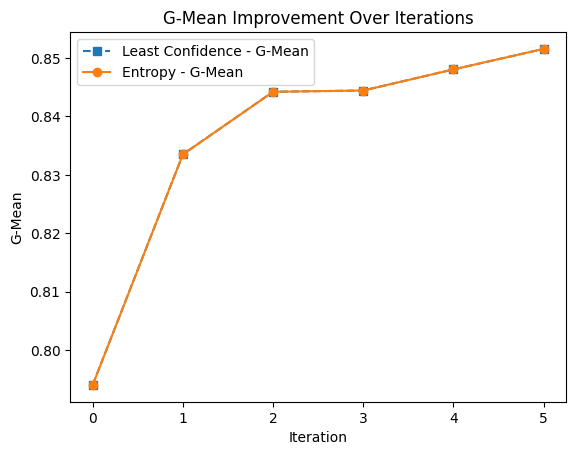

In [ ]:
plt.plot(iterations, lc_gmean, 's--', label='Least Confidence - G-Mean')
# plt.plot(iterations, entropy_gmean, 'o-', label='Entropy - G-Mean')
plt.title('G-Mean Improvement Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('G-Mean')
plt.legend()
plt.show()


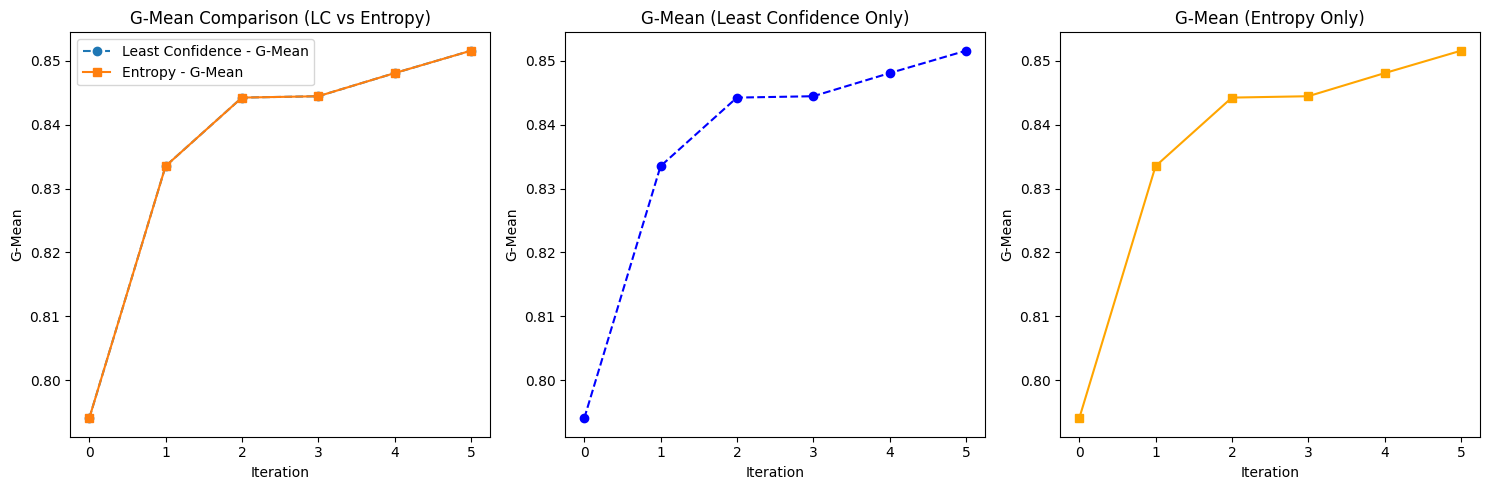

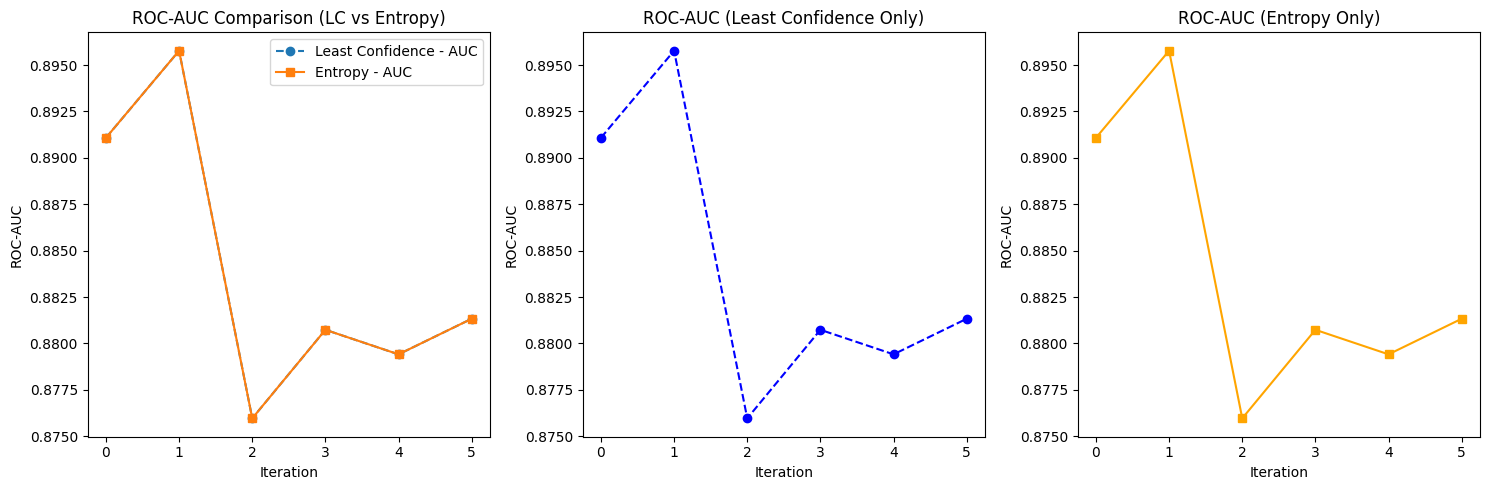

In [4]:
import matplotlib.pyplot as plt

# Assuming you have lists of iterations and the metrics as before
# iterations, lc_gmean, lc_auc, entropy_gmean, entropy_auc are defined
# For example:
# iterations = [0, 1, 2, 3, 4, 5]
# lc_gmean = [...]
# lc_auc = [...]
# entropy_gmean = [...]
# entropy_auc = [...]

# FIGURE 1: G-Mean
fig1, axs1 = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1 (G-Mean Comparison)
axs1[0].plot(iterations, lc_gmean, 'o--', label='Least Confidence - G-Mean')
axs1[0].plot(iterations, entropy_gmean, 's-', label='Entropy - G-Mean')
axs1[0].set_title('G-Mean Comparison (LC vs Entropy)')
axs1[0].set_xlabel('Iteration')
axs1[0].set_ylabel('G-Mean')
axs1[0].legend()

# Subplot 2 (G-Mean LC Only)
axs1[1].plot(iterations, lc_gmean, 'o--', color='blue')
axs1[1].set_title('G-Mean (Least Confidence Only)')
axs1[1].set_xlabel('Iteration')
axs1[1].set_ylabel('G-Mean')

# Subplot 3 (G-Mean Entropy Only)
axs1[2].plot(iterations, entropy_gmean, 's-', color='orange')
axs1[2].set_title('G-Mean (Entropy Only)')
axs1[2].set_xlabel('Iteration')
axs1[2].set_ylabel('G-Mean')

plt.tight_layout()
plt.show()

# FIGURE 2: ROC-AUC
fig2, axs2 = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1 (AUC Comparison)
axs2[0].plot(iterations, lc_auc, 'o--', label='Least Confidence - AUC')
axs2[0].plot(iterations, entropy_auc, 's-', label='Entropy - AUC')
axs2[0].set_title('ROC-AUC Comparison (LC vs Entropy)')
axs2[0].set_xlabel('Iteration')
axs2[0].set_ylabel('ROC-AUC')
axs2[0].legend()

# Subplot 2 (AUC LC Only)
axs2[1].plot(iterations, lc_auc, 'o--', color='blue')
axs2[1].set_title('ROC-AUC (Least Confidence Only)')
axs2[1].set_xlabel('Iteration')
axs2[1].set_ylabel('ROC-AUC')

# Subplot 3 (AUC Entropy Only)
axs2[2].plot(iterations, entropy_auc, 's-', color='orange')
axs2[2].set_title('ROC-AUC (Entropy Only)')
axs2[2].set_xlabel('Iteration')
axs2[2].set_ylabel('ROC-AUC')

plt.tight_layout()
plt.show()
